<a href="https://colab.research.google.com/github/epiasini/cbmm2018-dl-tutorials/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip3 install torch torchvision
%matplotlib inline

Transfer Learning tutorial
====================
This tutorial is adapted from the work of  [Sasank Chilamkurthy](https://chsasank.github.io), available with other tutorials from [the official PyTorch tutorials page](https://pytorch.org/tutorials/index.html).


In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at [cs231n
notes](http://cs231n.github.io/transfer-learning).

Quoting these notes,

    In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Today we will focus on the second scenario, namely **using a pre-trained convolutional neural network as a fixed feature extractor**. To do this, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os


Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

The data is available [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip>). We are going to download it and extract it to a local directory.



In [3]:
data_dir = 'hymenoptera_data'

# download data from torch website, then unzip
!if [ ! -d $data_dir ]; then wget https://download.pytorch.org/tutorial/hymenoptera_data.zip && unzip hymenoptera_data.zip; fi

In [4]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transform)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

Running on device: cuda:0


##Visualize a few training images


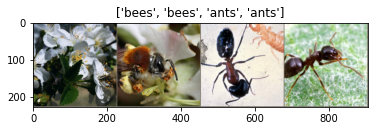

In [5]:
def imshow(inp, title=None, ax=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.grid(False)


# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Load the pre-trained network and set it up for our task

We start by loading a pretrained network. PyTorch makes it easy by having [a built-in library of useful models](https://pytorch.org/docs/stable/torchvision/models.html), that can be loaded with or without their pretrained weights. Let's load the 18-layer version of [ResNet](https://arxiv.org/abs/1512.03385), and ask for the pre-trained weights.




In [20]:
model_conv = torchvision.models.vgg16(pretrained=True)
print(model_conv)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Before training, we need to **freeze** all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed when we call ``backward()`` to perform backpropagation.

You can read more about this in the documentation
[here](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).

In [21]:
for param in model_conv.features.parameters():
    param.requires_grad = False # Parameters of newly constructed modules have requires_grad=True by default

In [22]:
# knowing that the last layer of the pre-trained network is model_conv.fc, get the number of inputs it has
num_ftrs = model_conv.classifier[0].in_features

# substitute it with a 2-layer perceptron with the same number of inputs but only 2 outputs
model_conv.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)

In [23]:
model_conv

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now that we have loaded and frozen the model, we can swap the last fully connected layer with a new layer that we will train for our task. If you observe the output of the print() function above, you will notice that the name of the last layer is `fc`, and that this fully connected layer has 512 input features and 1000 output features (the reason why there are 1000 output features is that this network has been trained to solve the 1000-class classification problem for the [ImageNet 2012](http://www.image-net.org/challenges/LSVRC/2012/) dataset). So we'll need to swap that with another fully connected layer with the same number of inputs (512) but only two outputs, as we are interested in a binary classification problem.


We are now ready to train the model.

In [25]:
# move the model to the GPU if available
model_conv = model_conv.to(device)

# define cross entropy loss
criterion = nn.CrossEntropyLoss()

# define the optimizer. Note that we tell the optimizer to only update the 
# parameters in the last layer. Also, remember that we have set requires_grad=False
# on all other parameters of the model, so the optimizer wouldn't have gradient
# information on them if we asked it to update all the parameters.
optimizer_conv = optim.Adam(model_conv.parameters())

## Train and evaluate


In [28]:
# generic training function
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [29]:
train_model(model_conv, criterion, optimizer_conv, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6448 Acc: 0.8361
val Loss: 0.3968 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.0208 Acc: 0.9877
val Loss: 0.5149 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.0162 Acc: 0.9918
val Loss: 0.6249 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.5750 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.6068 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.6160 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.6188 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.6296 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.6353 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.6408 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.6366 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.6399 Acc: 0.9346

Ep

## Visualize predictions

In [30]:
# generic function to visualize predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10,10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], ax=ax)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

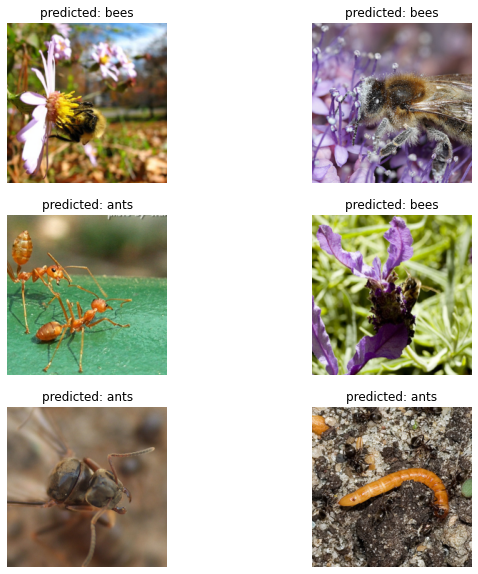

In [34]:
visualize_model(model_conv)



---

Let's move to the next tutorial: [recurrent neural network](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV).